# Imports

In [44]:
import api
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
#Set endpoint/URL and fetch data
url = 'https://api.jordbruksverket.se/rest/povapi/graderingar?fran=2010-08-04&till=2019-11-22&groda=Höstvete&skadegorare=blad'

#Takes a few seconds to process
df = api.fetch_data(url)

In [46]:

#Not needed as we are collecting for only this right now, altough could be useful in the future if we decide to fetch all of the data at once
#Can create a filter.py module similar to api.py
def filter_crop(df:pd.DataFrame, filter_groda:str)->pd.DataFrame:
    """Returns rows from df where 'groda' matches the given crop name"""
    filtered_df = df[df['groda'] == filter_groda]
    return filtered_df

#filtered_df = filter_groda(df, 'Höstvete')

def filter_area(df:pd.DataFrame, filter_delomrade:str)->pd.DataFrame:
    """Returns rows from df where 'delomrade' matches the given area name"""
    filtered_df = df[df['delomrade'] == filter_delomrade]
    return filtered_df

#filtered_df = df[df['delomrade'] == 'Blekinge']
#print(filtered_df)


df = api.sweref99tm_to_wgs84(df)

df_blekinge = filter_area(df, 'Blekinge')

print(df_blekinge)

     delomrade  ekologisk  forforfrukt     forfrukt  \
0     Blekinge      False      Rågvete      Rågvete   
1     Blekinge      False    Vall-gräs    Vall-gräs   
2     Blekinge      False      Rågvete   Oljeväxter   
3     Blekinge      False      Vårkorn        Ärter   
239   Blekinge      False       Övrigt     Höstvete   
240   Blekinge      False     Höstvete     Höstvete   
241   Blekinge      False  Sockerbetor      Potatis   
242   Blekinge      False      Vårkorn     Höstvete   
243   Blekinge      False      Vårkorn      Potatis   
477   Blekinge      False  Sockerbetor     Höstvete   
478   Blekinge      False      Potatis  Sockerbetor   
479   Blekinge      False   Oljeväxter     Höstvete   
480   Blekinge      False     Höstvete      Vårkorn   
481   Blekinge      False     Höstvete   Oljeväxter   
482   Blekinge      False     Höstvete        Ärter   
698   Blekinge      False     Höstvete  Sockerbetor   
699   Blekinge      False     Höstvete      Potatis   
700   Blek

In [67]:
def extract_pest(df: pd.DataFrame, pest: str) -> pd.DataFrame:
    """
    Look through df and extract data from 'graderingstillfalleList'.
    Extract records where 'skadegorare' == pest,
    Also adding other relevant information such as delomrade, lat-lon coordinates
    Needed since graderingslist is a list containing all measure instances for a given time period (year)
    """

    records = []

    for idx, row in df.iterrows():
        graderings_tillfallen = row.get('graderingstillfalleList', [])
        if not isinstance(graderings_tillfallen, list):
            continue

        #get area name, lat/long, etc
        delomrade_val = row.get('delomrade')
        lat_val = row.get('latitud')
        lon_val = row.get('longitud')
        crop = row.get('groda')
        sort = row.get('sort')

        for tillfalle in graderings_tillfallen:
            datum_str = tillfalle.get('graderingsdatum')
            datum_parsed = pd.to_datetime(datum_str, errors='coerce') if datum_str else None
            year = datum_parsed.year if pd.notnull(datum_parsed) else None

            graderingar = tillfalle.get('graderingList', [])
            for g in graderingar:
                if g.get('skadegorare') == pest:
                    varde_str = g.get('varde')
                    value = pd.to_numeric(varde_str, errors='coerce') if varde_str is not None else None
                    measuring_method = g.get('matmetod')

                    records.append({
                        "index_in_main_df": idx,
                        "delomrade": delomrade_val,
                        "latitud": lat_val,
                        "longitud": lon_val,
                        "date": datum_parsed,
                        "year": year,
                        "crop": crop,
                        "type": sort,
                        "pest": pest,
                        "measuring_method": measuring_method,
                        "value": value
                    })

    return pd.DataFrame(records)


df_blekinge_bf = extract_pest(df_blekinge, 'Bladfläcksvampar')



In [68]:
print(df_blekinge_bf.head())

   index_in_main_df delomrade    latitud   longitud       date  year  \
0                 0  Blekinge  56.106642  14.662357 2011-04-25  2011   
1                 0  Blekinge  56.106642  14.662357 2011-05-02  2011   
2                 0  Blekinge  56.106642  14.662357 2011-05-09  2011   
3                 0  Blekinge  56.106642  14.662357 2011-05-16  2011   
4                 0  Blekinge  56.106642  14.662357 2011-05-23  2011   

       crop   type              pest measuring_method  value  
0  Höstvete  Cubus  Bladfläcksvampar   % ang blad 1–3    5.0  
1  Höstvete  Cubus  Bladfläcksvampar   % ang blad 1–3    0.0  
2  Höstvete  Cubus  Bladfläcksvampar   % ang blad 1–3    0.0  
3  Höstvete  Cubus  Bladfläcksvampar   % ang blad 1–3    0.0  
4  Höstvete  Cubus  Bladfläcksvampar   % ang blad 1–3    0.0  


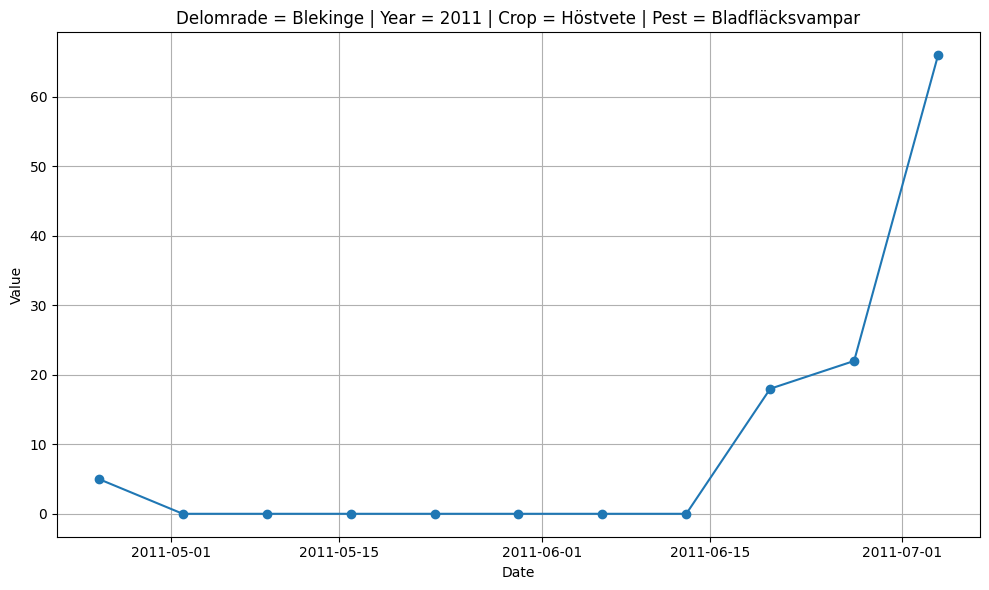

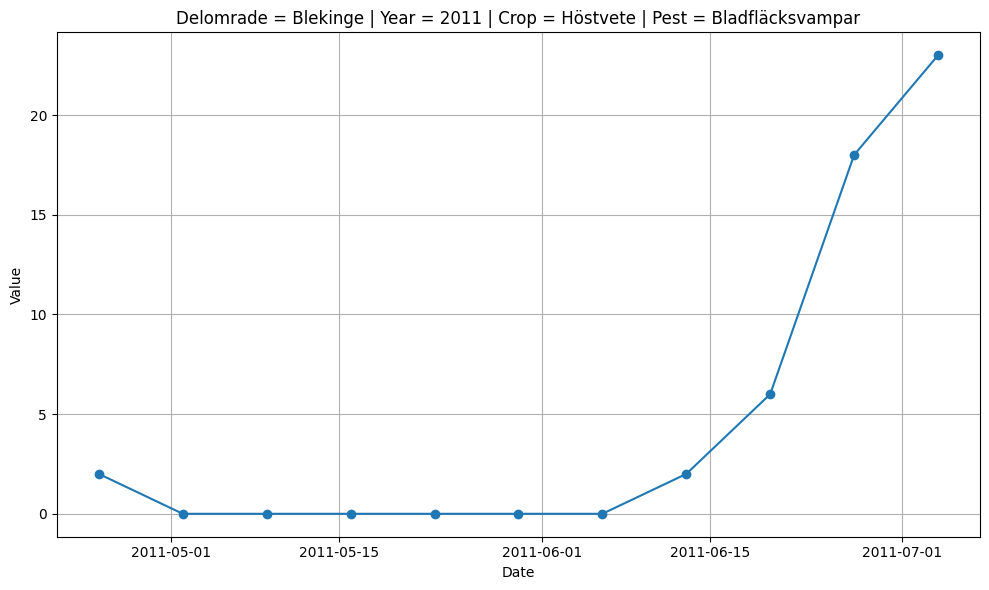

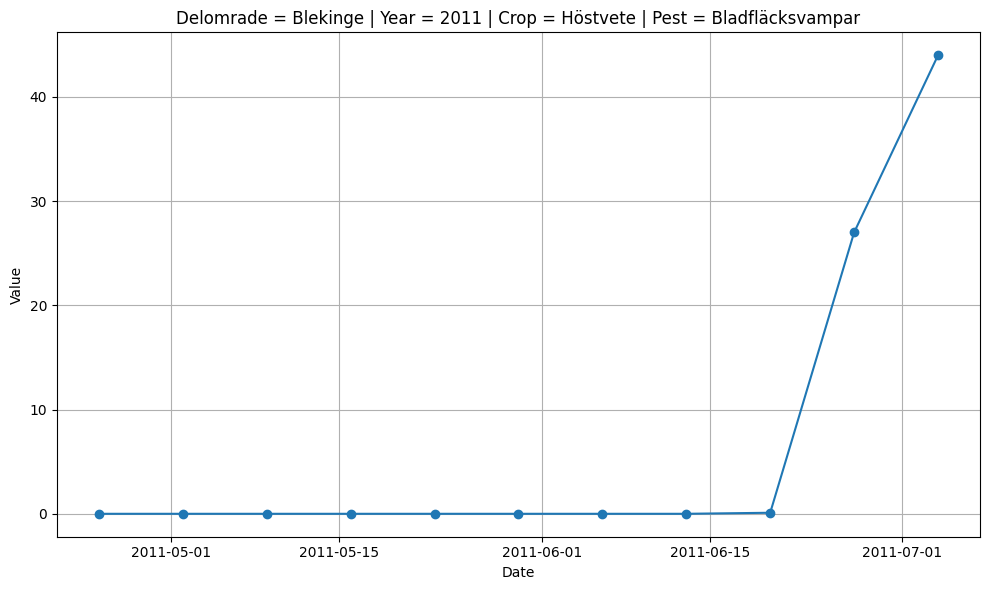

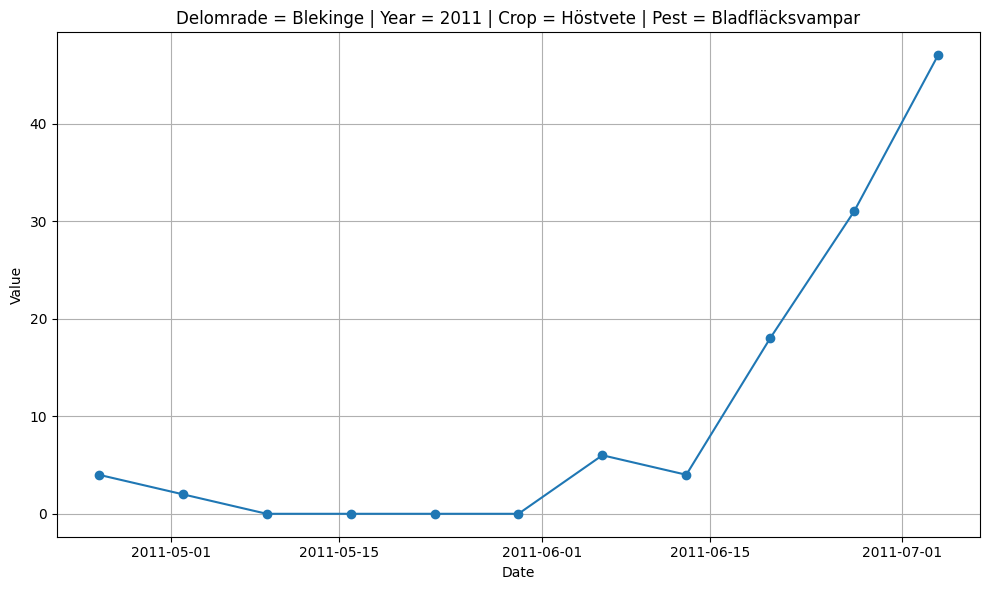

In [ ]:
def plot_pest_time_series(df: pd.DataFrame) -> None:
    if df.empty:
        print("No data to plot.")
        return

    df = df.sort_values("date")

    delomrade_vals = df["delomrade"].unique()
    year_vals = df["year"].unique()
    crop_vals = df["crop"].unique()
    pest_vals = df["pest"].unique()

    title_str = (
        f"Delomrade = {', '.join(map(str, delomrade_vals))} | "
        f"Year = {', '.join(map(str, year_vals))} | "
        f"Crop = {', '.join(map(str, crop_vals))} | "
        f"Pest = {', '.join(map(str, pest_vals))}"
    )

    plt.figure(figsize=(10, 6))
    plt.plot(df["date"], df["value"], marker='o', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(title_str)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for i in range(4):
    filtered_df2 = df_blekinge_bf[df_blekinge_bf["index_in_main_df"] == i]
    plot_pest_time_series(filtered_df2)